In [53]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [54]:
from traceTwoStateSimulation import tracePackageSimulation
from telegraph import exponential
from pol_signal import pol_signal
from loopFunction import SnailPromoterMs2Loops,loopInterpolate,tailUpMs2
from autocorrelationDataProcessing import tracePackageAutocorrelation

from autocorrelationAnalyticInference import fitAutocorrelationFunction

In [55]:
# define all needed parameters for simulation and fitting #
from loopFunction import DespondsMs2Loops

stepsize = 3.8            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

k_on = 0.0137
k_off = 0.0139
duration = 615   # seconds
num = 100           # number of traces in our simulated dataset

loop_function = tailUpMs2().loop_function

In [56]:
# simulated trace package
tracePackage = tracePackageSimulation(num, k_on, k_off, duration, stepsize, loop_function, k_elong, tPol)

In [57]:
# Now let's read in the CRISPR data
table = Table.read('crispr-data/Tailup/C09_040218_Emb1-data.csv')

In [58]:
len(table)

658

In [59]:
datatracelist = []
for name in table.colnames:
    datatracelist.append(table[name])

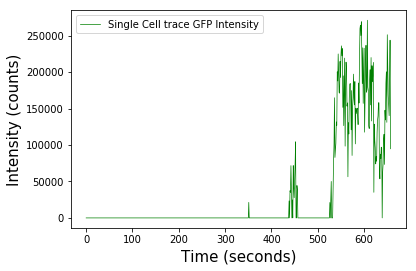

In [60]:
plt.plot(datatracelist[20], 'g', linewidth=0.7, label = 'Single Cell trace GFP Intensity')
plt.xlabel('Time (seconds)', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.legend(loc='best')

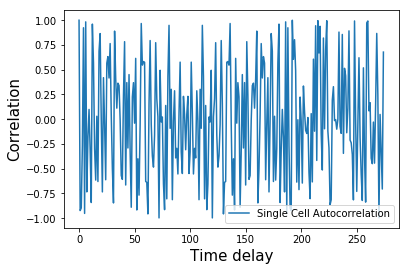

In [61]:
examp = np.correlate(datatracelist[14][300:], datatracelist[14][300:], 'same')
plt.plot(examp[np.argmax(examp):]/np.max(examp), label= 'Single Cell Autocorrelation')
plt.ylabel('Correlation', fontsize=15)
plt.xlabel('Time delay', fontsize=15)
plt.legend(loc='best')
plt.show()

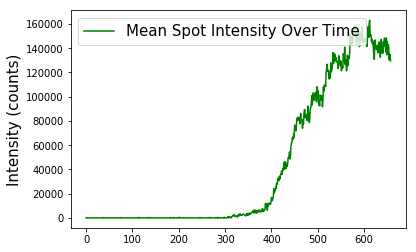

In [62]:
plt.plot(np.mean(datatracelist, axis=0), color='g', label='Mean Spot Intensity Over Time')
plt.legend(loc='best', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.show()

In [63]:
len(datatracelist[1])

658

In [64]:
# define start and stop indeces
start_index = 520
stop_index = -1

In [65]:
autopackage = tracePackageAutocorrelation(datatracelist, loop_function, start_index, stop_index)

In [66]:
t = np.arange(len(autopackage.tracelist[1][1:])) * stepsize

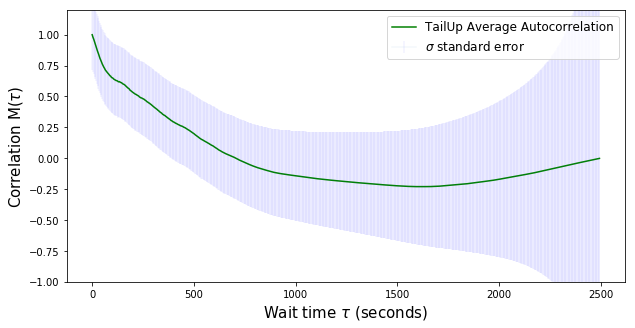

657


In [67]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
autoav = autopackage.autoav
autostd = autopackage.autostd
avgflors = autopackage.avgflors

ax.plot(t, autoav, color = 'g', label = "TailUp Average Autocorrelation")
ax.errorbar(x=t, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.05, label = r'$\sigma$ standard error')  
ax.legend(loc='best', fontsize='large')
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'Correlation M($\tau$)', fontsize=15)
ax.set_ylim(-1, 1.2)
plt.show()

print(len(autoav))

In [68]:
# fit for pon in a SIMPLE way
def fitPon(autopackage, loop_function):
    avg_flors = autopackage.avgflors
    pon = np.mean(avg_flors / np.sum(loop_function)) 
    pon_std = np.std(avg_flors/ np.sum(loop_function)) 

    return pon,pon_std

In [69]:
pon,pon_std = fitPon(autopackage, loop_function)
print(pon)

0.13055255386134967


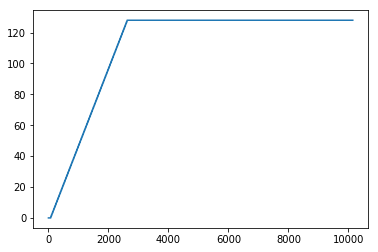

In [70]:
plt.plot(loop_function)


In [71]:
def loopInterpolate(loop_function, k_elong, tPol):
    sizePol = k_elong * tPol
    loop_fn_interp = []
    counter=0
    for i in range(len(loop_function)):
        if counter / sizePol >= 1:
            loop_fn_interp.append(loop_function[i])
            counter=0
        else:
            counter += 1
    return np.asarray(loop_fn_interp)
        

In [72]:
interploop = loopInterpolate(loop_function, k_elong, tPol)

len(interploop)

67

In [73]:
def autocorr(t, ratesum):  # take in parameters and t (signal data array index in seconds)
    # define all needed parameters #
    despondsfile = 'standalone/therightL.mat'
    stepsize = 6            # time between observations, seconds
    tPol=6;                 # polII loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * k_elong     # Footprint, in basepairs, of polII
    
    time = np.arange(len(t)) * stepsize
    
    tracelength = len(t)        # calculate from trace inputs
    
    # get the loop function
    loops = interploop
    # do the Pon fitting (once I've written the function)
    # pon,pon_upper,pon_lower = pon_fit()
    
    # FOR NOW:
    #p_on = fitPon(tracelist)
    p_on = 0.133
    p_off = 1-p_on

    # write analytic autocorrelation function according to Desponds et al:    
    # chartime is defined as k_on + k_off
    
    delta = 1 - ratesum    
   
       
    # write a for loop to do the double sums to compute connected correlation:
    
    c_arr = []
    
    for t in range(len(time)):
        sm0 = 0
        for i in range(len(loops)):
            for j in range(len(loops)):
                sm0 += p_on*p_off*(loops[i] * loops[j] * np.exp((delta-1)*np.abs(t - j + i)))
     
        c_arr.append(sm0)
    #plt.plot(c_arr)
           
    connected_corr = np.asarray(c_arr)    # the two-state connected correlation function
    #return connected_corr / np.max(connected_corr)
   
    N = len(time)         # CONSTANT trace length
    
    # Add in the finite trace correction for the Ornstein-Uhlenbeck process    
    # perform the summations
    
    # initialize corrected lists
    corrected_full = []
    Co = connected_corr[0]    # initial condition of connected correlation function
        
    # Now we're going to correct EVERY data point in the connected autocorrelation function
    for r in range(len(connected_corr)):
    
        sm1 = 0    
        for k in range(1,N):
            sm1 += 2*(N - k)*connected_corr[k]
    
        sm2 = 0   
        for j in range(1,r):
            sm2 += 2*(r-j)*connected_corr[j]

        sm3 = 0
        for m in range(1,N):
            sm3 += connected_corr[m] * (np.min(np.asarray([m+r, N])) - np.max(np.asarray([r, m])))
    
        # full correction
        corrected_full.append((connected_corr[r] + 
                                    (1/N) *((1/N) - (2./(N-r))) * (N*Co + sm1)) + ((2/(N*(N-r))) * (r*Co + sm2 + sm3)))
    
    normed = np.asarray(corrected_full)
    
    return (normed / normed[1])

In [74]:
fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong)

In [75]:
kon_fit,koff_fit,chrtime,pon,pcov = fitAutoPack.leastSquaresAutoFit()

C:\Users\tmakinen\repositories\bursting-IGMM\autocorrelation\autocorrelationAnalyticInference.py:118: RuntimeWarning: overflow encountered in double_scalars
  sm0 += p_on*p_off*(loops[i] * loops[j] * np.exp((delta-1)*np.abs(t - j + i)))
C:\Users\tmakinen\repositories\bursting-IGMM\autocorrelation\autocorrelationAnalyticInference.py:138: RuntimeWarning: overflow encountered in double_scalars
  sm1 += 2*(N - k)*connected_corr[k]
C:\Users\tmakinen\repositories\bursting-IGMM\autocorrelation\autocorrelationAnalyticInference.py:146: RuntimeWarning: invalid value encountered in double_scalars
  sm3 += connected_corr[m] * (np.min(np.asarray([m+r, N])) - np.max(np.asarray([r, m])))
C:\Users\tmakinen\repositories\bursting-IGMM\autocorrelation\autocorrelationAnalyticInference.py:149: RuntimeWarning: invalid value encountered in double_scalars
  (1/N) *((1/N) - (2./(N-r))) * (N*Co + sm1)) + ((2/(N*(N-r))) * (r*Co + sm2 + sm3)))
C:\Users\tmakinen\repositories\bursting-IGMM\autocorrelation\autocorre

Pon                       =  0.13055255386134967
k_on + k_off              =  0.01248987869114601 s^-1
k_on                      =  0.001630585560547563
k_off                     =  0.010859293130598446
t_polII_block             =  6 seconds
characteristic timescale  =  80.06482886890592 time units
covariance                =  2.093750942464044e-07


In [76]:
# get our data's average autocorrelation function
t = np.arange(len(autoav))

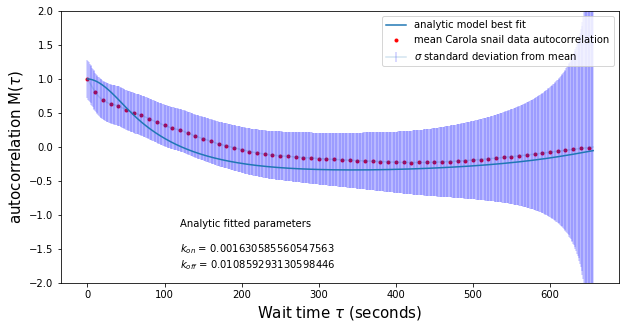

In [77]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)

ax.plot(t, fitAutoPack.autocorrAnalytic(t,1/chrtime), label='analytic model best fit')
#for i in autolist[1:]:
    #plt.plot(t, i[1:], color='b', alpha=0.1)

ax.scatter(t[::10],autoav[::10], marker='.', 
                   color='r', label = 'mean Carola snail data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(np.arange(len(autoav)),dat, color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
ax.errorbar(x=t, y=autoav, yerr=(autostd, autostd), 
                        ecolor='b', alpha=0.2, label = r'$\sigma$ standard deviation from mean')  

#plt.plot(chrtime, 1/(np.e), size=20, color='r')
plt.legend(loc="best")
ax.set_ylim(-2, 2)
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'autocorrelation M($\tau$)', fontsize=15)
#plt.text(x=0.07, y=-1.8, 
             #s='Simulated Parameters \n\n$k_{on}$ =' + str(k_on) +
                    # '\n$k_{off}$ = ' + str(k_off) +  '\n$k_{elong}$ = '+ str(k_elong) 
                             #+ ' bp/sec \nobservation time = '+ str(stepsize) + ' seconds')
plt.text(x=120, y=-1.8, s='Analytic fitted parameters \n\n$k_{on}$ = ' 
                                 + str(kon_fit) + '\n$k_{off}$ = ' + str(koff_fit))
plt.show()